In [4]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from src.classifiers.denoise_net import *
from src.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from src.DenoiseSolver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Data Generation

In [20]:
# Generate sample data
# We generate a single piecewise constant sequence x_orig

def generate_piecewise_const_signal(length, num_blocks=20):   
    l = length
    x_orig = np.zeros((l,1))
    max_block_len = l/5
    for k in xrange(num_blocks):
        start = np.random.random_integers(0,l-1)
        end = np.random.random_integers(start,start+max_block_len)
        val = np.random.rand() - 0.5
        x_orig[start:end,0] = 2*val
    return x_orig

def create_denoise_data(orig_sig, N, D,sigma=0.01):
    X_train = np.zeros((N,D))
    for sample in xrange(N):
        X_train[sample,:] = orig_sig[sample:(sample+D),0] + sigma*np.random.randn(D)
    y_train = orig_sig[0:N,0]
    return X_train, y_train

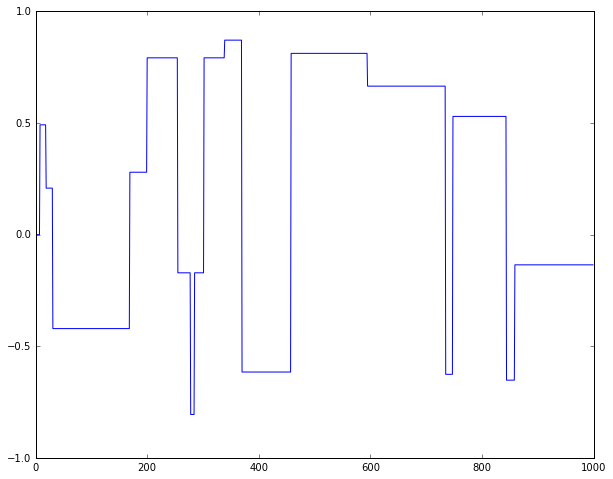

In [21]:
len = 1000
N = 200
D = 400

# generate original signal
x_orig = generate_piecewise_const_signal(len,40)
plt.plot(x_orig);


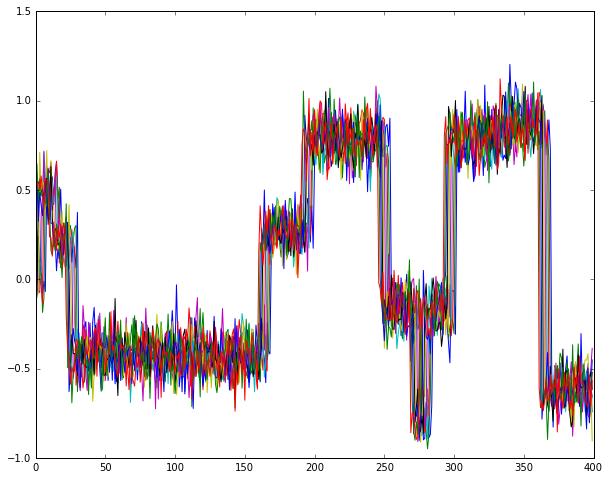

In [36]:
X_train,y_train = create_denoise_data(x_orig, N, D,0.1);
for sample in xrange(10):
    plt.plot(X_train[sample,:])


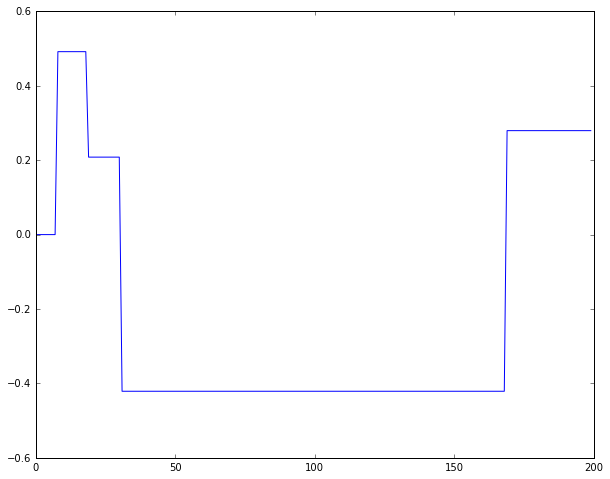

In [37]:
plt.plot(y_train);

# Loss layers: TV loss
Evaluate the numerical gradient to check if the loss function is implemented correctly

Testing tv_loss:
loss:  0.0105261328913
dx error:  1.164303029e-11


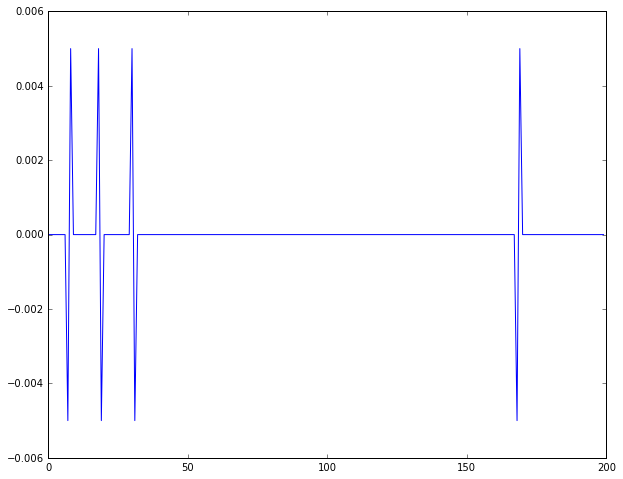

In [38]:
dx_num = eval_numerical_gradient(lambda y: tv_loss(y_train)[0], y_train, verbose=False)
loss, dx = tv_loss(y_train)

# Test tv_loss function. 
print 'Testing tv_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)

plt.plot(dx)

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [39]:
H1, H2 = 15, 20
# X = np.random.randn(N, D)
# y = np.random.randint(C, size=(N,))
np.reshape(y_train,(N,1))
print y_train.shape

for reg in [0, 100]:
  print 'Running check with reg = ', reg
  model = DenoiseFCNet([H1, H2], input_dim=D, output_dim=1,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X_train, y_train)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X_train, y_train)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

(200,)
Running check with reg =  0
Initial loss:  0.0744634987906
W1 relative error: 4.14e-05
W2 relative error: 4.68e-06
W3 relative error: 2.10e-09
b1 relative error: 3.74e-08
b2 relative error: 1.97e-08
b3 relative error: 1.84e-11
Running check with reg =  100
Initial loss:  0.367793575196
W1 relative error: 1.32e-07
W2 relative error: 4.37e-08
W3 relative error: 6.33e-11
b1 relative error: 3.42e-09
b2 relative error: 4.02e-10
b3 relative error: 1.09e-11


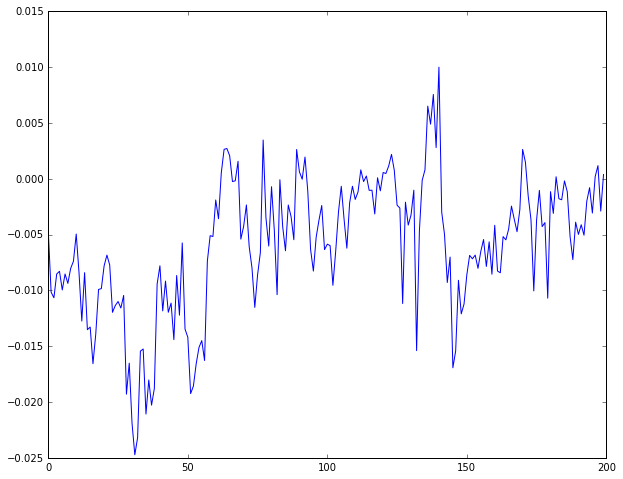

In [40]:
scores = model.loss(X_train)
plt.plot(scores);

## Overfit the data
As another sanity check, we overfit the Denoise Net

(Iteration 1 / 2000) loss: 0.078111
(Iteration 101 / 2000) loss: 0.001393
(Iteration 201 / 2000) loss: 0.000512
(Iteration 301 / 2000) loss: 0.000476
(Iteration 401 / 2000) loss: 0.000798
(Iteration 501 / 2000) loss: 0.000012
(Iteration 601 / 2000) loss: 0.000132
(Iteration 701 / 2000) loss: 0.000546
(Iteration 801 / 2000) loss: 0.000002
(Iteration 901 / 2000) loss: 0.000001
(Iteration 1001 / 2000) loss: 0.000001
(Iteration 1101 / 2000) loss: 0.000113
(Iteration 1201 / 2000) loss: 0.000314
(Iteration 1301 / 2000) loss: 0.000072
(Iteration 1401 / 2000) loss: 0.000000
(Iteration 1501 / 2000) loss: 0.000162
(Iteration 1601 / 2000) loss: 0.000071
(Iteration 1701 / 2000) loss: 0.000000
(Iteration 1801 / 2000) loss: 0.000065
(Iteration 1901 / 2000) loss: 0.000074


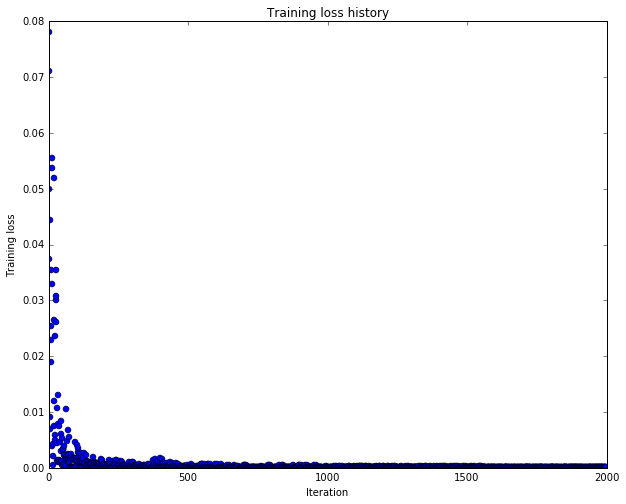

In [41]:
# TODO: Use a three-layer Net to overfit 50 training examples.

# Needs to be changed 
small_data = {
  'X_train': X_train,
  'y_train': y_train,
  'X_val': X_train,
  'y_val': y_train,
}

weight_scale = 1e-2 #1e-2
reg = 0.01;
learning_rate = 5e-2 #1e-4
model = DenoiseFCNet([100],input_dim=D,output_dim=1,reg=reg,weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=100, num_epochs=1000, batch_size=100,
                update_rule='sgd_momentum',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

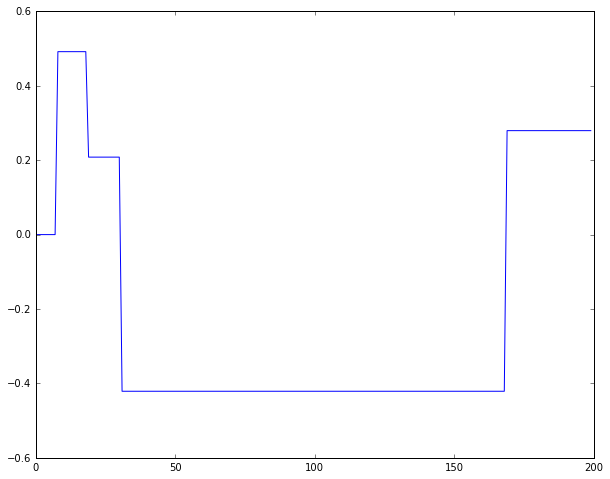

In [42]:
scores = model.loss(X_train)
plt.plot(y_train)

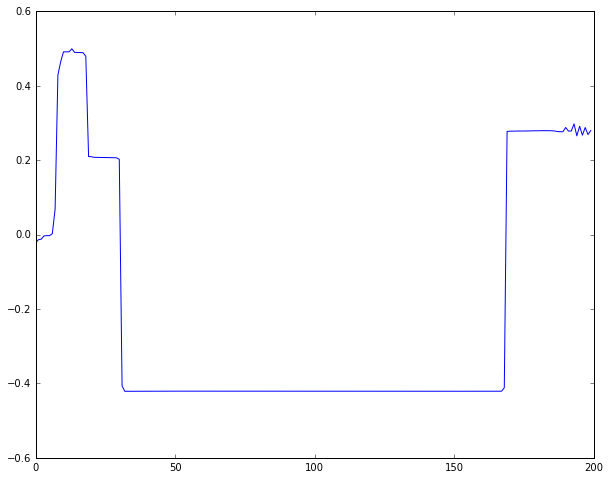

In [43]:
scores = model.loss(X_train)
plt.plot(scores);

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print 'next_w error: ', rel_error(expected_next_w, next_w)
print 'cache error: ', rel_error(expected_cache, config['cache'])

In [ ]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print 'next_w error: ', rel_error(expected_next_w, next_w)
print 'v error: ', rel_error(expected_v, config['v'])
print 'm error: ', rel_error(expected_m, config['m'])

Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print 'running with ', update_rule
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
best_model = None
best_val_acc = -1
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
max_count = 20
for count in xrange(max_count):
    reg = 10**np.random.uniform(-4,-2)
    lr = 10**np.random.uniform(-1,-4)
#     print 'reg: ',reg, ' lr: ',lr
    model = FullyConnectedNet([256, 128, 128, 64], dropout=0.25, 
                              use_batchnorm=True, reg=reg, weight_scale=5e-2)
       
    solver = Solver(model, data, update_rule='adam', optim_config={
                'learning_rate': lr}, lr_decay=0.95, num_epochs=10, 
                batch_size=100, verbose=False)
    solver.train()        
    
    train_acc = solver.train_acc_history[-1]
    val_acc = solver.val_acc_history[-1]
    print 'train_acc: ', train_acc, 'val acc: ', val_acc, ', lr: ', lr, ', reg: ', reg
    if val_acc > best_val_acc:
        val_acc = best_val_acc
        best_model = model
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
# Training the best model for a longer time
lr = 0.000845028050079
reg = 0.000154770877635
best_model = FullyConnectedNet([256, 128, 128, 64], dropout=0.25, 
                          use_batchnorm=True, reg=reg, weight_scale=5e-2)

solver = Solver(best_model, data, update_rule='adam', optim_config={
            'learning_rate': lr}, lr_decay=0.95, num_epochs=20, 
            batch_size=100, verbose=True, print_every=200)
solver.train()        

train_acc = solver.train_acc_history[-1]
val_acc = solver.val_acc_history[-1]
print 'train_acc: ', train_acc, 'val acc: ', val_acc, ', lr: ', lr, ', reg: ', reg

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()